## Copyright

Copyright 2020 The Google Research Authors.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Imports

In [ ]:
import numpy as np
from scipy.optimize import minimize
import functools
import matplotlib.pyplot as plt
from tensorflow.io import gfile

In [ ]:
import palettable

## This is the energy distance loss

In [ ]:
def loss(param, sample_from_param_fun, real_data, repulsive_term = True):
  sample = sample_from_param_fun(param)
  d_real_fake = np.sqrt(np.sum(np.square(sample - real_data), axis=1))
  perm = np.random.RandomState(seed=100).permutation(sample.shape[0])
  sample2 = sample[perm]
  d_fake_fake = np.sqrt(np.sum(np.square(sample - sample2), axis=1))
  l = 2. * np.mean(d_real_fake)
  if repulsive_term:
    l -= np.mean(d_fake_fake)
  return l

## Fitting a high dimensional Gaussian using energy distance, with and without using a repulsive term

In [ ]:
n = 10000
dim = 100
def sample_from_param(param, z):
  mu = param[:-1]
  log_sigma = param[-1]
  sigma = np.exp(log_sigma)
  mu = np.reshape(mu, [1, dim])
  return mu + sigma * z

z_optim = np.random.normal(size=(n, dim))
sample_from_param_partial = functools.partial(sample_from_param, z=z_optim)

In [ ]:
# real data
real_param = np.zeros(dim+1)
real_data = sample_from_param(real_param, np.random.normal(size=(n, dim)))

In [ ]:
# with energy distance
res = minimize(loss,
               np.zeros(dim + 1),
               args=(sample_from_param_partial, real_data, True),
               method='BFGS',
               tol=1e-10)
sample_ged = sample_from_param_partial(res.x)

In [ ]:
# without repulsive
res = minimize(loss,
               np.zeros(dim + 1),
               args=(sample_from_param_partial, real_data, False),
               method='BFGS',
               tol=1e-10)
sample_naive = sample_from_param_partial(res.x)

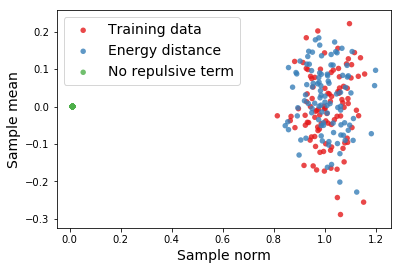

In [ ]:
def data_to_xy(sample):
  sample = sample[:100]
  x = np.sqrt(np.mean(np.square(sample), axis=1))
  y = np.mean(sample, axis=1)
  return (x,y)

data = (data_to_xy(real_data), data_to_xy(sample_ged), data_to_xy(sample_naive))
colors = palettable.colorbrewer.qualitative.Set1_3.mpl_colors
groups = ("Training data", "Energy distance", "No repulsive term")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x, y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.legend(loc='best', fontsize=14)
plt.xlabel('Sample norm', fontsize=14)
plt.ylabel('Sample mean', fontsize=14)
plt.show()

with gfile.GFile('ed_high_dim.pdf', 'wb') as fh:
  fig.savefig(fh, format='pdf')

In [ ]:
%download_file ed_high_dim.pdf

## Fitting a mixture of 3 Gaussians in 2d

In [ ]:
n = 10000
def sample_from_param(param, z, perm):
  params = np.split(param, 3)
  means = [np.reshape(p[:2], [1,2]) for p in params]
  sigmas = [np.exp(p[2]) for p in params]
  samples = [m + s*zi for m,s,zi in zip(means, sigmas, z)]
  samples = np.concatenate(samples, axis=0)[perm]
  return samples

z_optim = np.split(np.random.normal(size=(n, 6)), 3, axis=1)
perm_optim = np.random.permutation(3*n)
sample_from_param_partial = functools.partial(sample_from_param,
                                              z=z_optim,
                                              perm=perm_optim)

In [ ]:
# real data
real_param = np.array([-10., 0., 0., 10., 0., 0., 0., np.sqrt(300.), 0.])
z_real = np.split(np.random.normal(size=(n, 6)), 3, axis=1)
perm_real = np.random.permutation(3*n)
real_data = sample_from_param(real_param, z=z_real, perm=perm_real)

In [ ]:
# with energy distance
res = minimize(loss,
               np.zeros(9),
               args=(sample_from_param_partial, real_data, True),
               method='BFGS',
               tol=1e-10)
sample_ged = sample_from_param_partial(res.x)

In [ ]:
# without repulsive
res = minimize(loss,
               np.zeros(9),
               args=(sample_from_param_partial, real_data, False),
               method='BFGS',
               tol=1e-10)
sample_naive = sample_from_param_partial(res.x)

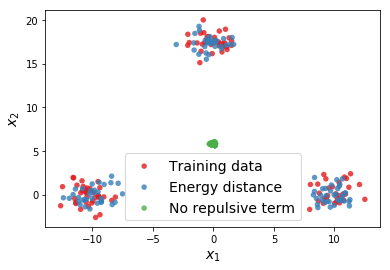

In [ ]:
def data_to_xy(sample):
  sample = sample[:100]
  x,y = np.split(sample,2,axis=1)
  return (x,y)

data = (data_to_xy(real_data), data_to_xy(sample_ged), data_to_xy(sample_naive))
colors = palettable.colorbrewer.qualitative.Set1_3.mpl_colors
groups = ("Training data", "Energy distance", "No repulsive term")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
  x, y = data
  ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.legend(loc='best', fontsize=14)
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.show()

with gfile.GFile('ed_3gaussians.pdf', 'wb') as fh:
  fig.savefig(fh, format='pdf')

In [ ]:
%download_file ed_3gaussians.pdf